# Stat Analysis

In [68]:
import pandas as pd
import os
import numpy as np 
import statsmodels.formula.api as smf
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as st 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [88]:
# read in combined dataframe
combo_df = pd.read_csv("combined_df.txt")

# rename first column to name of benchmarks 
combo_df.rename(columns={'Unnamed: 0':'Benchmark'}, inplace=True)

# drop duplicates
#df[df['ids'].str.contains('ball', na = False)] # valid for (at least) pandas version 0.17.1
#combo_df[combo_df['Benchmark'].str.contains("\(1\)", na=False)]
combo_df = combo_df[combo_df['Benchmark'].str.contains('(1)')]
#df[df['ids'].str.contains("ball")]

#df[df['model'].str.contains('ac')]

print(len(combo_df.index))

# drop informational messages
combo_df = combo_df.drop(['I'], axis=1)

# drop fatal error messages
combo_df = combo_df.drop(['F'], axis=1)

# turn Nan to zero
combo_df = combo_df.fillna(0)

# print first few lines of dataframe 
combo_df.head()

# combine high and medium severity counts into one category
combo_df['BANDIT_MED_HIGH'] = combo_df['TOTAL_BANDIT'].subtract(combo_df['LOW_SEVERITY'])

print(combo_df['Benchmark'])

379
0                          AuthBWC-0.1.3
1            AuthBWC-0.1.3_pylint(1).txt
3             Beaker-0.9.3_pylint(1).txt
4                           CLAM-0.9.9.1
5             CLAM-0.9.9.1_pylint(1).txt
6                        CairoSVG-1.0.20
7          CairoSVG-1.0.20_pylint(1).txt
9       CherryMusic-0.35.2_pylint(1).txt
10                             DPLib-1.3
14                          Flask-0.12.2
15                     Flask-Admin-1.2.0
16                Flask-Exceptions-1.0.1
17                    Flask-Images-1.1.2
18                    Flask-Logger-1.0.2
19                  Flask-Micropub-0.2.1
21             Flask-Security-Fork-1.8.0
22              Flask-StatsDClient-2.0.1
25                        Henosis-0.0.10
27                              IM-1.4.8
28                             Jinja-1.2
29                          Jinja2-2.7.1
30                           Kotti-1.3.1
34                         Misago-0.19.3
37             Paste-0.9.3_pylint(1).txt
39          

/Users/ruthjohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.


# Step 1: Overview of data
- i) Distribution of Pylint types of errors
- ii) Distribution of types of security vulnerabilities
- iii) Distribution of security vulnerabilties by severity 

In [70]:
# basic statistics

# total benchmarks
total_benchmarks = len(combo_df.index)
print("Total benchmarks: %d" % total_benchmarks)

# how many benchmarks had at least 1 bandit error
total_benchmarks_bandit = len(combo_df.loc[combo_df['TOTAL_BANDIT'] > 0].index)
print("Total benchmarks with >=1 bandit error: %d" % total_benchmarks_bandit)

# avg number of pylint errors
total_benchmarks_pylint = len(combo_df.loc[combo_df['TOTAL_PYLINT'] > 0].index)
print("Total benchmarks with >=1 pylint error: %d" % total_benchmarks_pylint)

Total benchmarks: 379
Total benchmarks with >=1 bandit error: 231
Total benchmarks with >=1 pylint error: 371


## i. Distribution of Pylint types of errors

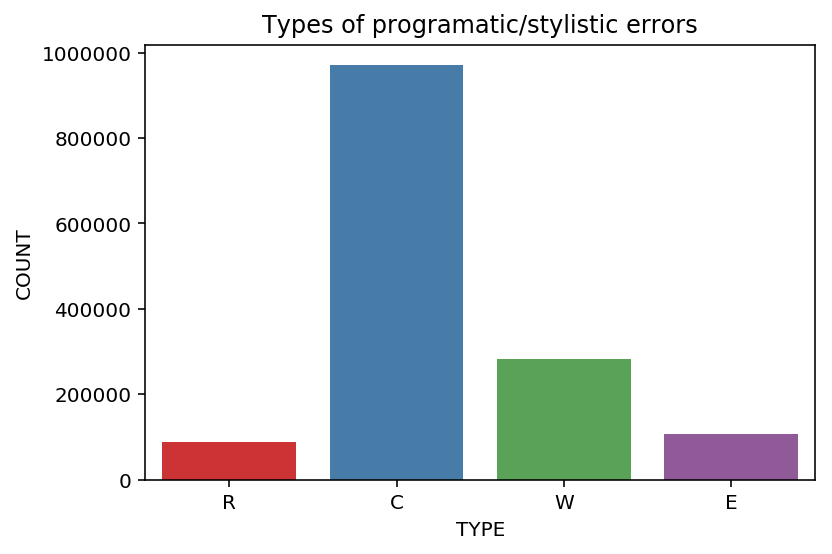

  TYPE   COUNT  PERCENT
R    R   88525  6.11288
C    C  969890  66.9734
W    W  282566  19.5119
E    E  107190  7.40175


In [89]:
sum_col = combo_df.apply('sum')
pylint_count = sum_col.filter(items=['I', 'R','C','W','E','F'])
pylint_count_df = pd.DataFrame({'TYPE': pylint_count.index, 'COUNT': pylint_count})
pylint_count_df['PERCENT'] = pylint_count_df['COUNT'].divide(pylint_count_df['COUNT'].sum())*100
g = sns.barplot(x="TYPE", y="COUNT", data=pylint_count_df, palette='Set1')
plt.title("Types of programatic/stylistic errors")
plt.show()
plt.close()

print(pylint_count_df)

## ii) Distribution of types of security vulnerabilities

In [72]:
# List of bandit tests from https://github.com/PyCQA/bandit
test_ids = ["B101", "B102", "B103", "B104", "B105", "B106", "B107", "B108", "B109", "B110", "B111", "B112"]
test_ids += ["B201"]
test_ids += ["B301", "B302", "B303", "B304", "B305", "B306", "B307", "B308", "B309", "B310"]
test_ids += ["B311", "B312", "B313", "B314", "B315", "B316", "B317", "B318", "B319", "B320"]
test_ids += ["B321", "B322", "B323", "B324", "B325"]
test_ids += ["B401", "B402", "B403", "B404", "B405", "B406", "B407", "B408", "B409", "B410", "B411", "B412", "B413"]
test_ids += ["B501", "B502", "B503", "B504", "B505", "B506", "B507"]
test_ids += ["B601", "B602", "B603", "B604", "B605", "B606", "B607", "B608", "B609", "B610", "B611"]
test_ids += ["B701", "B702", "B703"]

sum_col = combo_df.apply('sum')
bandit_count = sum_col.filter(items=test_ids)
bandit_count_df = pd.DataFrame({'TYPE': bandit_count.index, 'COUNT': bandit_count})
bandit_count_df['PERCENT'] = bandit_count_df['COUNT'].divide(bandit_count_df['COUNT'].sum())*100

print(bandit_count_df.sort_values(by='PERCENT', ascending=False))
#g = sns.barplot(x="TYPE", y="COUNT", data=bandit_count_df, palette='Set1')
#plt.title("Types of security vulnerabilities")

      TYPE  COUNT     PERCENT
B101  B101  37440     81.8629
B603  B603    881     1.92631
B110  B110    795     1.73827
B311  B311    689      1.5065
B105  B105    663     1.44966
B106  B106    571      1.2485
B108  B108    559     1.22226
B404  B404    438    0.957691
B303  B303    320    0.699683
B607  B607    312    0.682191
B310  B310    278     0.60785
B403  B403    206    0.450421
B307  B307    204    0.446048
B608  B608    185    0.404504
B104  B104    178    0.389199
B301  B301    176    0.384826
B605  B605    156    0.341095
B102  B102    150    0.327976
B320  B320    140    0.306111
B701  B701    139    0.303925
B602  B602    128    0.279873
B504  B504     98    0.214278
B410  B410     86     0.18804
B322  B322     79    0.172734
B405  B405     72    0.157429
B406  B406     71    0.155242
B312  B312     69    0.150869
B318  B318     55    0.120258
B408  B408     47    0.102766
B506  B506     45   0.0983929
...    ...    ...         ...
B309  B309     16   0.0349841
B610  B610

## Top 10 types of security vulneratbilities

In [73]:
sorted_bandit_count = bandit_count.sort_values(ascending=False)
sorted_bandit_count[:10]

# assert used
# try_except_pass
# subprocess_without_shell_equals_true
# hardcoded_password_string
# hardcoded_password_funcarg
# random
# import_pycrypto
# hardcoded_tmp_directory
# import_subprocess
# md5

B101    37440
B603      881
B110      795
B311      689
B105      663
B106      571
B108      559
B404      438
B303      320
B607      312
dtype: object

In [74]:
# which programs had most high severity issues
high_severity_bandit_df = combo_df.sort_values(by='HIGH_SEVERITY', ascending=False)
#print(high_severity_bandit_df['Benchmark'][:10])

# top 10 normalized by benchmark size 
high_severity_bandit_df['HIGH_SEVERITY_NORM'] = high_severity_bandit_df['HIGH_SEVERITY'].divide(high_severity_bandit_df['BENCHMARK_SIZE'])
high_severity_bandit_df = high_severity_bandit_df.sort_values(by='HIGH_SEVERITY_NORM', ascending=False)
print(high_severity_bandit_df['Benchmark'][:10])
print(combo_df.columns)
# --> be careful using any types of security, crypto, networking-related libraries 

29            Jinja2-2.7.1
473      python-jose-1.3.1
58              Pyro4-4.71
556              yasha-3.1
132         block-io-1.1.6
511      sftp-cloudfs-0.13
545         verifone-0.1.7
4             CLAM-0.9.9.1
465    pytest-shutil-1.0.1
453       pypiserver-1.1.6
Name: Benchmark, dtype: object
Index(['Benchmark', 'I', 'R', 'C', 'W', 'E', 'F', 'TOTAL_PYLINT', 'B101',
       'B102', 'B103', 'B104', 'B105', 'B106', 'B107', 'B108', 'B109', 'B110',
       'B111', 'B112', 'B201', 'B301', 'B302', 'B303', 'B304', 'B305', 'B306',
       'B307', 'B308', 'B309', 'B310', 'B311', 'B312', 'B313', 'B314', 'B315',
       'B316', 'B317', 'B318', 'B319', 'B320', 'B321', 'B322', 'B323', 'B324',
       'B325', 'B401', 'B402', 'B403', 'B404', 'B405', 'B406', 'B407', 'B408',
       'B409', 'B410', 'B411', 'B412', 'B413', 'B501', 'B502', 'B503', 'B504',
       'B505', 'B506', 'B507', 'B601', 'B602', 'B603', 'B604', 'B605', 'B606',
       'B607', 'B608', 'B609', 'B610', 'B611', 'B701', 'B702', 'B703',
 

# iii) Distribution of security vulnerabilties by severity

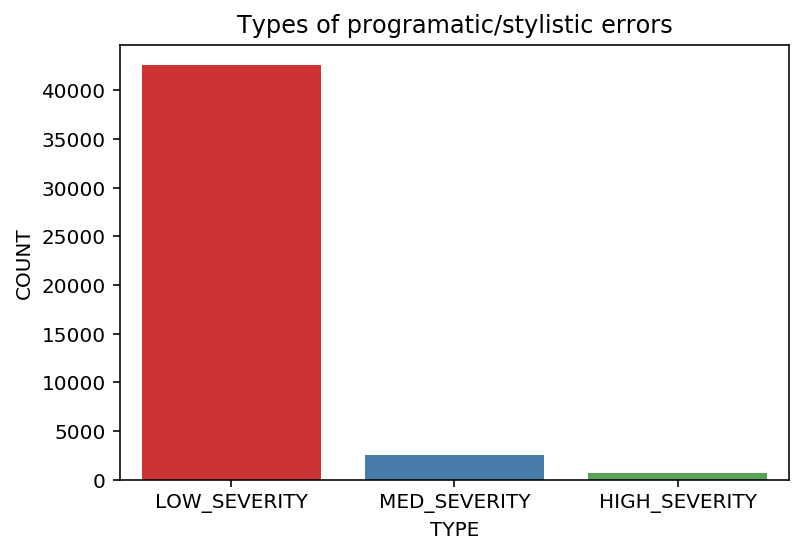

                        TYPE  COUNT  PERCENT
LOW_SEVERITY    LOW_SEVERITY  42539  93.0119
MED_SEVERITY    MED_SEVERITY   2549  5.57341
HIGH_SEVERITY  HIGH_SEVERITY    647  1.41467


In [75]:
sum_col = combo_df.apply('sum')
pylint_count = sum_col.filter(items=['LOW_SEVERITY', 'MED_SEVERITY', 'HIGH_SEVERITY'])
pylint_count_df = pd.DataFrame({'TYPE': pylint_count.index, 'COUNT': pylint_count})
pylint_count_df['PERCENT'] = pylint_count_df['COUNT'].divide(pylint_count_df['COUNT'].sum())*100

g = sns.barplot(x="TYPE", y="COUNT", data=pylint_count_df, palette='Set1')
plt.title("Types of programatic/stylistic errors")
plt.show()
plt.close()

print(pylint_count_df)

# Step 2: Relationship between total errors and total vulnerabilities
- i) vanilla linear regression
- ii) multivariate regression by type of error
- iii) regression by severity 
- iv) different types of severity driven by types of errors
- v) looking into outliers

### i) univariate relationship between total pylint errors and total bandit errors

r^2: 0.03775 (0.0001411)
correlation: 0.1943 (0.0001411)


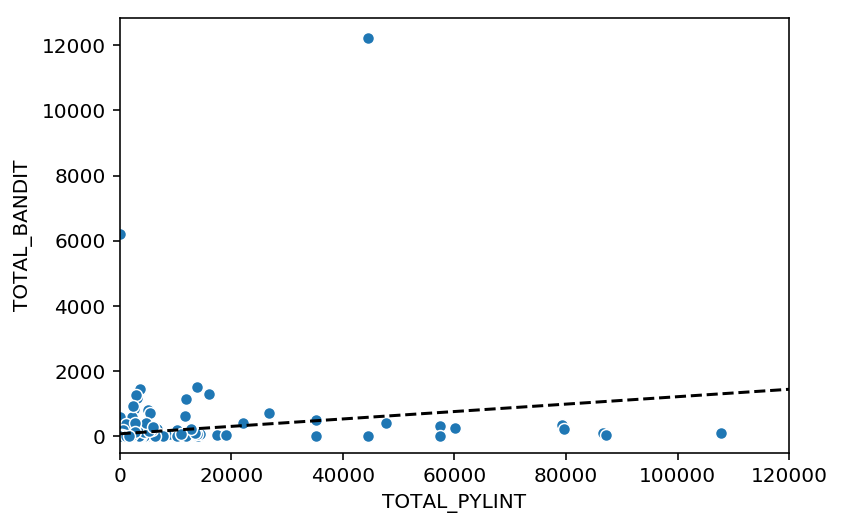

In [76]:
slope, intercept, r_square, p_value, std_err = st.linregress(x=combo_df['TOTAL_PYLINT'].values, y=combo_df['TOTAL_BANDIT'].values)
x = np.arange(1,150000)
y = slope*x+intercept

model = smf.ols('TOTAL_BANDIT ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()

r_square = model.rsquared
p_value = model.f_pvalue

corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['TOTAL_BANDIT'].values)

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

sns.scatterplot(x='TOTAL_PYLINT', y='TOTAL_BANDIT', data=combo_df, palette='Set1')
plt.plot(x, y, linestyle='--', color='black')
plt.ylim(-500.0)
plt.xlim(0, 120000)
plt.show()

## ii) multivariate regression of total bandit errors by type of pylint error

In [77]:
model = smf.ols('TOTAL_BANDIT ~ R + C + W + E', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

                            OLS Regression Results                            
Dep. Variable:           TOTAL_BANDIT   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     33.54
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           6.38e-24
Time:                        12:01:49   Log-Likelihood:                -2976.9
No. Observations:                 379   AIC:                             5964.
Df Residuals:                     374   BIC:                             5983.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.9231     34.067      1.407      0.1

## iii) univariate analysis of total pylint errors versus high, med, low severity issues

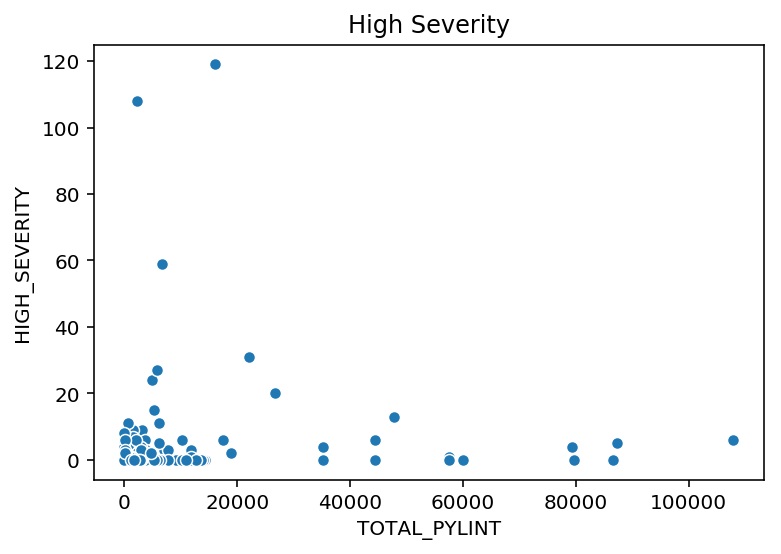

r^2: 0.01175 (0.03493)
correlation: 0.1084 (0.03493)


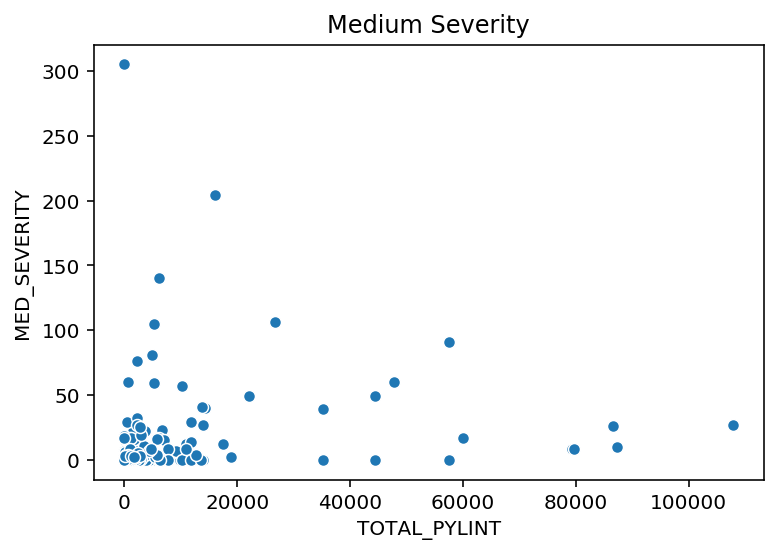

r^2: 0.04739 (1.909e-05)
correlation: 0.2177 (1.909e-05)


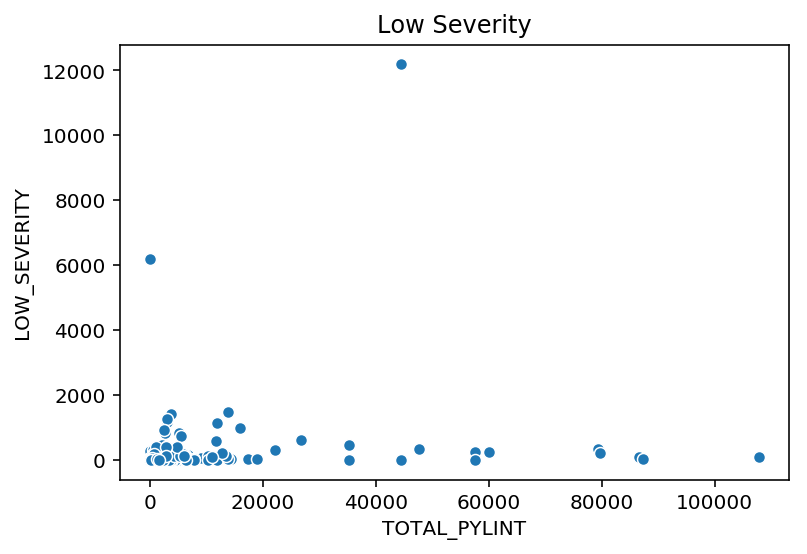

r^2: 0.03505 (0.0002471)
correlation: 0.1872 (0.0002471)


In [78]:
model = smf.ols('HIGH_SEVERITY ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='TOTAL_PYLINT', y='HIGH_SEVERITY', data=combo_df, palette='Set1')
plt.title("High Severity")
plt.show()
plt.close()
corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['HIGH_SEVERITY'].values)

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

model = smf.ols('MED_SEVERITY ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='TOTAL_PYLINT', y='MED_SEVERITY', data=combo_df, palette='Set1')
plt.title("Medium Severity")
plt.show()
plt.close()

corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['MED_SEVERITY'].values)
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

model = smf.ols('LOW_SEVERITY ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='TOTAL_PYLINT', y='LOW_SEVERITY', data=combo_df, palette='Set1')
plt.title("Low Severity")
plt.show()
plt.close()
corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['LOW_SEVERITY'].values)
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))



## iv) severity of vulnerabilities driven by different types of pylint errors 

In [79]:
model = smf.ols('HIGH_SEVERITY ~ R + C + W + E', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

model = smf.ols('MED_SEVERITY ~  R + C + W + E ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

model = smf.ols('LOW_SEVERITY ~ R + C + W + E ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)


                            OLS Regression Results                            
Dep. Variable:          HIGH_SEVERITY   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.367
Date:                Sun, 09 Jun 2019   Prob (F-statistic):             0.0524
Time:                        12:01:52   Log-Likelihood:                -1376.4
No. Observations:                 379   AIC:                             2763.
Df Residuals:                     374   BIC:                             2783.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2761      0.499      2.556      0.0

## v) take into account benchmark size

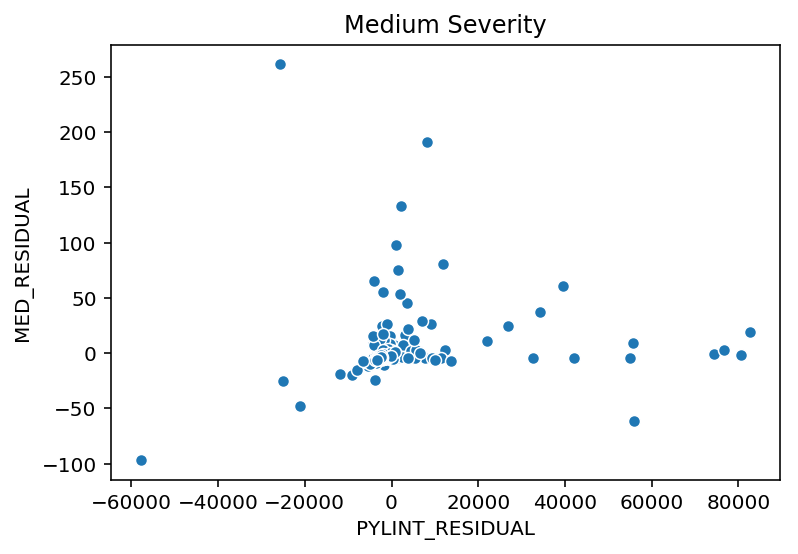

r^2: 0.009211 (0.06197)
correlation: 0.09597 (0.06197)


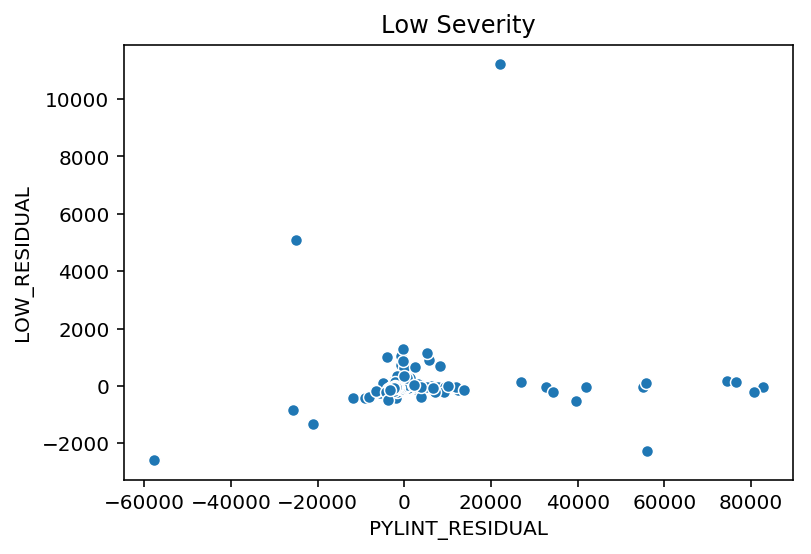

r^2: 0.005562 (0.1473)
correlation: 0.07458 (0.1473)


In [83]:
results = smf.ols('TOTAL_BANDIT ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['TOTAL_BANDIT'].values - Y_pred
combo_df['BANDIT_RESIDUAL'] = residual

results = smf.ols('TOTAL_PYLINT ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['TOTAL_PYLINT'].values - Y_pred
combo_df['PYLINT_RESIDUAL'] = residual


results = smf.ols('LOW_SEVERITY ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['LOW_SEVERITY'].values - Y_pred
combo_df['LOW_RESIDUAL'] = residual

results = smf.ols('MED_SEVERITY ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['MED_SEVERITY'].values - Y_pred
combo_df['MED_RESIDUAL'] = residual

results = smf.ols('HIGH_SEVERITY ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['HIGH_SEVERITY'].values - Y_pred
combo_df['HIGH_RESIDUAL'] = residual

model = smf.ols('MED_RESIDUAL ~ PYLINT_RESIDUAL', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='PYLINT_RESIDUAL', y='MED_RESIDUAL', data=combo_df, palette='Set1')
plt.title("Medium Severity")
plt.show()
plt.close()

corr_coef, rho_pvalue = st.pearsonr(combo_df['PYLINT_RESIDUAL'].values, combo_df['MED_RESIDUAL'].values)
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

model = smf.ols('LOW_RESIDUAL ~ PYLINT_RESIDUAL', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='PYLINT_RESIDUAL', y='LOW_RESIDUAL', data=combo_df, palette='Set1')
plt.title("Low Severity")
plt.show()
plt.close()
corr_coef, rho_pvalue = st.pearsonr(combo_df['PYLINT_RESIDUAL'].values, combo_df['LOW_RESIDUAL'].values)
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))



In [84]:
results = smf.ols('TOTAL_BANDIT ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])

residual = combo_df['TOTAL_BANDIT'].values - Y_pred
combo_df['RESIDUAL'] = residual

results = smf.ols('R ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
R_residual = combo_df['R'].values - Y_pred
combo_df['R_RESIDUAL'] = R_residual

results = smf.ols('C ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
C_residual = combo_df['C'].values - Y_pred
combo_df['C_RESIDUAL'] = C_residual

results = smf.ols('W ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
W_residual = combo_df['W'].values - Y_pred
combo_df['W_RESIDUAL'] = W_residual

results = smf.ols('E ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
E_residual = combo_df['E'].values - Y_pred
combo_df['E_RESIDUAL'] = E_residual

results = smf.ols('TOTAL_BANDIT ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['TOTAL_BANDIT'].values - Y_pred
combo_df['BANDIT_RESIDUAL'] = residual

results = smf.ols('TOTAL_PYLINT ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
residual = combo_df['TOTAL_PYLINT'].values - Y_pred
combo_df['PYLINT_RESIDUAL'] = residual

###################

# overall bandit vs pylint
model = smf.ols('BANDIT_RESIDUAL ~ PYLINT_RESIDUAL ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

###################

# overall bandit stratified by type of errors
model = smf.ols('BANDIT_RESIDUAL ~  R_RESIDUAL + C_RESIDUAL + W_RESIDUAL + E_RESIDUAL', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

###################

# stratify be severity
model = smf.ols('LOW_RESIDUAL ~ R_RESIDUAL + C_RESIDUAL + W_RESIDUAL + E_RESIDUAL ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

###################

# stratify by severity
model = smf.ols('MED_RESIDUAL ~ R_RESIDUAL + C_RESIDUAL + W_RESIDUAL + E_RESIDUAL ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)


###################

# stratify by severity
model = smf.ols('HIGH_RESIDUAL ~ R_RESIDUAL + C_RESIDUAL + W_RESIDUAL + E_RESIDUAL ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)


                            OLS Regression Results                            
Dep. Variable:        BANDIT_RESIDUAL   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.324
Date:                Sun, 09 Jun 2019   Prob (F-statistic):              0.128
Time:                        16:00:37   Log-Likelihood:                -3013.1
No. Observations:                 379   AIC:                             6030.
Df Residuals:                     377   BIC:                             6038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.776e-14     35.340   5.

# plots for presentation

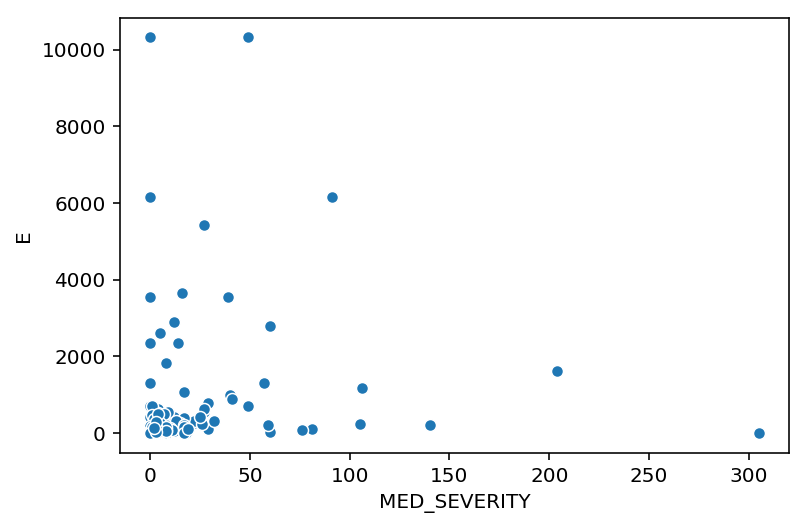

In [90]:
sns.scatterplot(combo_df['MED_SEVERITY'], combo_df['E'])
plt.show()